# 3D plotting

* [mplot3d tutorial¶](https://jakevdp.github.io/mpl_tutorial/tutorial_pages/tut5.html)
* [Matplotlib Tutorial: 5. 3D plotting](https://jakevdp.github.io/mpl_tutorial/tutorial_pages/tut5.html)

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple
)
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
#%matplotlib inline

In [2]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

# Data

In [3]:
def set_in_a_radius(radius: float, d: int, n: int):
    """Generate cartesian coordinate points in a radius in a D dimension space.
    Args:
        radius: A distance within which data points are to be generated
        d: dimensions
        n: number of points to generate
    Returns:
        cartesians: data points in cartesian coordinate of shame (N,D)

    Mapping from n-spherical coordinate to a Cartesian coordinate.
    https://en.wikipedia.org/wiki/N-sphere#Spherical_coordinates
    https://math.stackexchange.com/questions/991169

    Unlearn the (x, y, z) coordinates and work on according to the dimensions.
    In a n-spherical coordinate, a point P = (radius, Θ1, Θ2, ... Θi, ..., Θd-1).
    Θi is an angle form axis i to the vector P. Then the xi in a Cartesian system
    xi = cos(Θi) * sin(i+1) * ... * sin(Θd-2) * sin(Θd-1) when i > 0.
    xi = sin(Θi) * sin(i+1) * ... * sin(Θd-2) * sin(Θd-1) when i = 0.
    """
    assert n > 0 and d > 0, radius > 0.0

    # --------------------------------------------------------------------------------
    # Radii with one radius per each data point.
    # Radians for (d - 1) dimensions in a data point (minus 1 for radius dimension)
    # --------------------------------------------------------------------------------
    radii: np.ndarray = np.random.uniform(0, radius, n).reshape((n, 1))
    radians: np.ndarray = np.random.uniform(0, 2 * np.pi, (n, d - 1))

    # --------------------------------------------------------------------------------
    # numpy universal function to generate sin(Θi) * sin(i+1) * ... * sin(Θd-1) at i,
    # then accumulate them for each i.
    # --------------------------------------------------------------------------------
    def func(left, right):
        return left * right

    ufunc = np.frompyfunc(func, 2, 1)

    # --------------------------------------------------------------------------------
    # Generate sin(Θd-1) * ... * sin(i+1) * sin(Θi) for each i in (1, 2, ... d-1).
    # Add ones at column 0, which is later placed at the last column (d-1) in (N,D),
    # after reversed, then becomes cos(Θd-1) as the cartesian coordinate X[(d-1)].
    #
    # Apply ufunc to radians:(N, D-1) without reversing along axis=-1 because there is
    # no-order in the array "radians" before apply ufunc as they are random.
    # Reverse the result sin(Θi) * ... sin(i+1) * sin(Θd-1) along the axis -1 to form
    # [ sin(Θ1) * ... * sin(Θd-1), ..., sin(Θi) * ... * sin(Θd-1), ..., sin(Θd-1), 1 ].
    # --------------------------------------------------------------------------------
    cartesians = np.c_[np.ones(n), np.sin(radians)]
    ufunc.accumulate(
        cartesians,
        axis=-1,
        dtype=np.ndarray,
        out=cartesians
    ).astype(float)
    cartesians = np.flip(cartesians, axis=-1)

    # --------------------------------------------------------------------------------
    # cos(Θi) to generate xi = cos(Θi) * sin(i+1) * ... * sin(Θd-1) for i > 0.
    # Ones at d=0 so that x0 = sin(Θ1) * sin(Θ1 ) * ... * sin(Θd-1) for i = 0.
    # cosins = [1, cos(Θ1), cos(Θ2), ... cos(Θd-1)]
    # --------------------------------------------------------------------------------
    cosines = np.c_[np.ones(n), np.cos(radians)]

    # --------------------------------------------------------------------------------
    # Element multiply cosines [1, cos(Θ1), cos(Θ2), ... cos(Θd-1)] with
    # [ sin(Θ1) * ... * sin(Θd-1), ..., sin(Θi) * ... * sin(Θd-1), ..., sin(Θd-1), 1 ]
    # generates:
    # cos(Θi) * sin(i+1) * ... * sin(Θd-2) * sin(Θd-1) when i > 1.
    # sin(Θi) * sin(i+1) * ... * sin(Θd-2) * sin(Θd-1) when i = 0.
    # --------------------------------------------------------------------------------
    np.multiply(cosines, cartesians, out=cartesians)
    np.multiply(radii, cartesians, out=cartesians)

    del radii, cosines

    return cartesians

# Shpere in Wireframe

* [Plotting a 3d cube, a sphere and a vector in Matplotlib](https://stackoverflow.com/a/11156353/4281353)

In [4]:
from itertools import product, combinations
def draw_sphere(ax, radius, color='indigo'):
    # draw cube
    assert radius > 0
    r = [-radius, radius]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s-e)) == r[1]-r[0]:
            ax.plot3D(*zip(s, e), color="olive", alpha=0.8)

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = radius * np.cos(u) * np.sin(v)
    y = radius * np.sin(u) * np.sin(v)
    z = radius * np.cos(v)
    ax.plot_wireframe(x, y, z, color=color, alpha=0.2)

    # draw a point
    # ax.scatter([0], [0], [0], color="g", s=100)


<IPython.core.display.Javascript object>


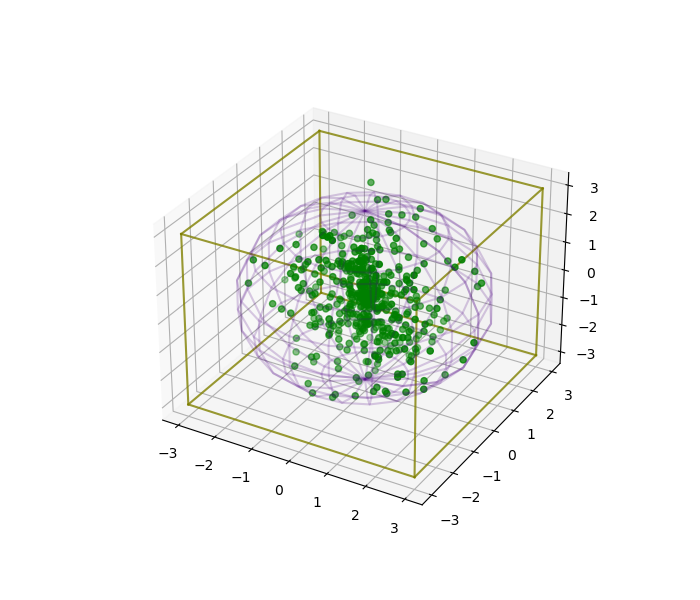

In [5]:
N = 500
D = 3
radius = 3
Z = set_in_a_radius(radius=radius, n=N, d=D)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('auto')
ax.scatter(Z[::, 0], Z[::, 1], Z[::, 2], color='green')
draw_sphere(ax, radius)
ax.grid()

# Arrow

* [Plotting a 3d cube, a sphere and a vector in Matplotlib](https://stackoverflow.com/a/11156353/4281353)

<IPython.core.display.Javascript object>


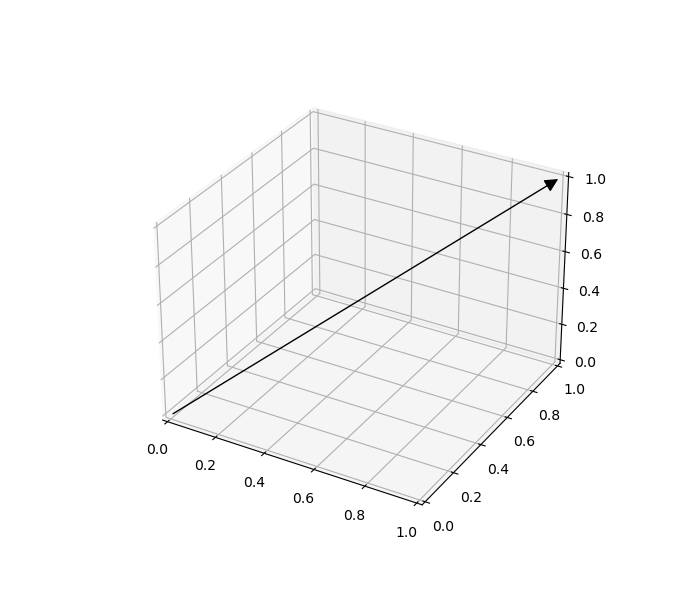

In [10]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
a = Arrow3D([0, 1], [0, 1], [0, 1], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
ax.add_artist(a)

# Line

<IPython.core.display.Javascript object>


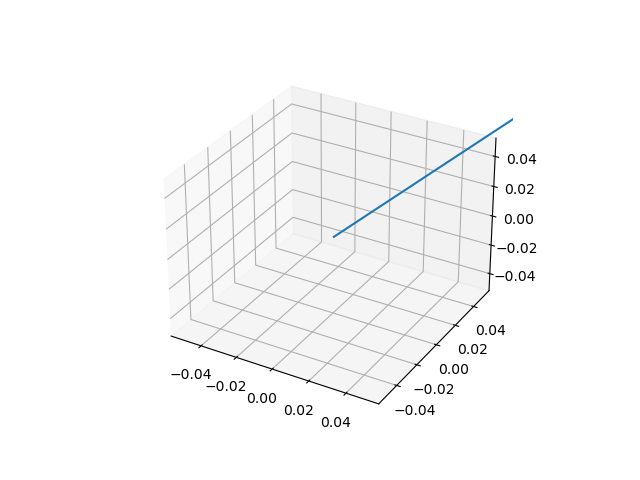

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.gca(projection='3d')

#draw the arrow
ax.quiver(0,0,0,1,1,1,length=1.0)

plt.show()

# Hyperplane

* [Plot am plane based on a normal vector and a point in Matlab or matplotlib
](https://stackoverflow.com/questions/3461869/plot-a-plane-based-on-a-normal-vector-and-a-point-in-matlab-or-matplotlib)

<IPython.core.display.Javascript object>


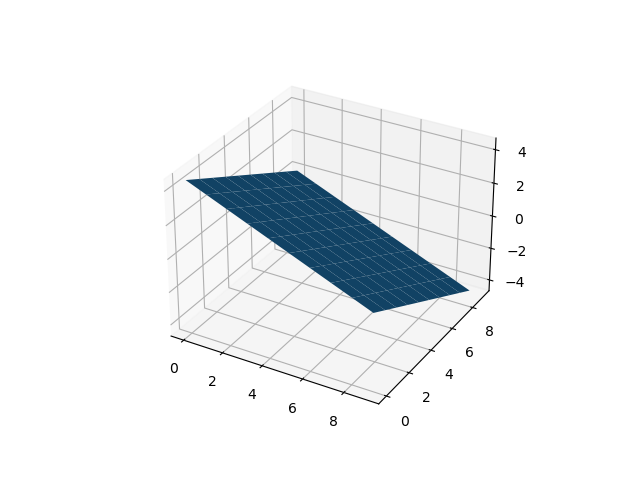

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

point  = np.array([1, 2, 3])
normal = np.array([1, 1, 2])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(10), range(10))

# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

# plot the surface
plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(xx, yy, z)
plt.show()

<IPython.core.display.Javascript object>


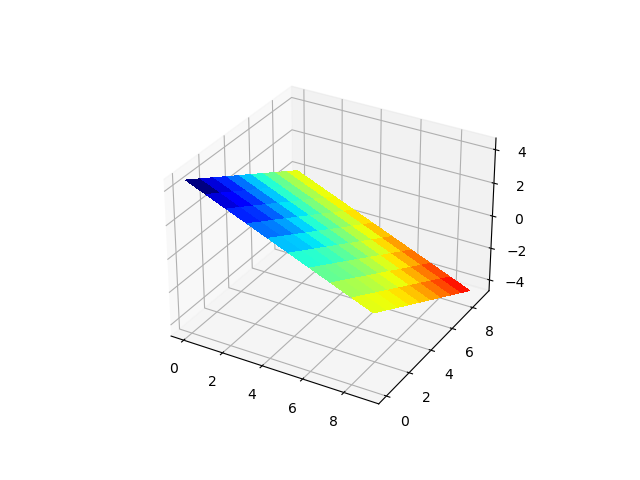

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

point = np.array([1, 2, 3])
normal = np.array([1, 1, 2])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(10), range(10))

# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

# plot the surface
plt3d = plt.figure().gca(projection='3d')

Gx, Gy = np.gradient(xx * yy)  # gradients with respect to x and y
G = (Gx ** 2 + Gy ** 2) ** .5  # gradient magnitude
N = G / G.max()  # normalize 0..1

plt3d.plot_surface(xx, yy, z, rstride=1, cstride=1,
                   facecolors=cm.jet(N),
                   linewidth=0, antialiased=False, shade=False
)
plt.show()